In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from collections import Counter
from itertools import product

from sklearn.metrics import f1_score

from sys import path

path.append("../utils/")

from utils import get_datasets

In [7]:
#DATASETS = ["webkb", "20ng", "acm", "reut"]
DATASETS = ["webkb"]#, "20ng", "acm", "reut"]

#CLFS = ["kpr", "ktr", "lpr", "ltr", "sfr", "stmk", "xfr", "xpr", "xtr", "kfr", "ktmk", "lfr", "ltmk", "spr", "str", "xlnet_softmax", "xtmk", "rep_bert"]
#CLFS = ["kfr", "kpr", "ktmk", "ktr"]#, "xpr", "xtmk", "kfr"]
CLFS = ["kfr", "kpr", "ktmk", "ktr", "lfr", "lpr", "ltmk", "rep_bert"]

In [8]:
pd_datasets = get_datasets(DATASETS)

In [44]:
d_probas = {}
for dset in DATASETS:
    d_probas[dset] = {}
    for clf in CLFS:
        lprobas = []
        for fold in np.arange(10):
            probs_path = f"/home/welton/data/calibrated_probabilities/split_10/{dset}/10_folds/{clf}/{fold}/test.npz"
            #probs_path = f"/home/welton/data/clfs_output/split_10/{dset}/10_folds/{clf}/{fold}/test.npz"
            lprobas.append(np.load(probs_path)["X_test"])
        d_probas[dset][clf] = np.vstack(lprobas)

In [45]:
def plot_bar(probas, hits):
    unique, counts = np.unique(probas, return_counts=True)
    confidence_count = dict(zip(unique, counts))

    y1 = []; y2 = []
    keys = list(confidence_count.keys())
    keys.sort()
    labels = []
    for key in keys:
        y1.append(confidence_count[key])
        y2.append( hits[key] if key in hits else 0 )
        upper_key = np.round(key + 0.1, decimals=1)
        labels.append(f"{key} - {upper_key}")
    x = np.arange(len(y1))

    plt.bar(x, y1, alpha=0.5, label="Confidence Counts")
    plt.bar(x, y2, alpha=0.5, label="Hits Counts")
    _ = plt.xticks(ticks=x, labels=labels, rotation=90)
    plt.legend(fontsize=14)

In [46]:
def plot_proba_dist(d_probas, pd_datasets, dset, clf):
    predictions = d_probas[dset][clf].argmax(axis=1)
    probas = []
    hits = {}
    df = pd_datasets[dset]
    hits_count = 0
    # For each prediction
    for idx, predicted_class in enumerate(predictions):
        # Getting the probability of the predicted class
        probability = d_probas[dset][clf][idx][predicted_class] * 10
        bean = np.trunc(probability) / 10
        bean = 0.9 if bean >= 1 else bean
        probas.append(bean)
        if predicted_class == df.classes.values[idx]:
            if bean not in hits:
                hits[bean] = 0
            hits[bean] += 1
            hits_count += 1
    
    #print(f"{dset.upper()} - {clf.upper()} - MaF1: {f1_score(d_labels[dset], predictions, average='macro')} - Hits {hits_count}")
    plot_bar(probas, hits)


# MetaFeatures

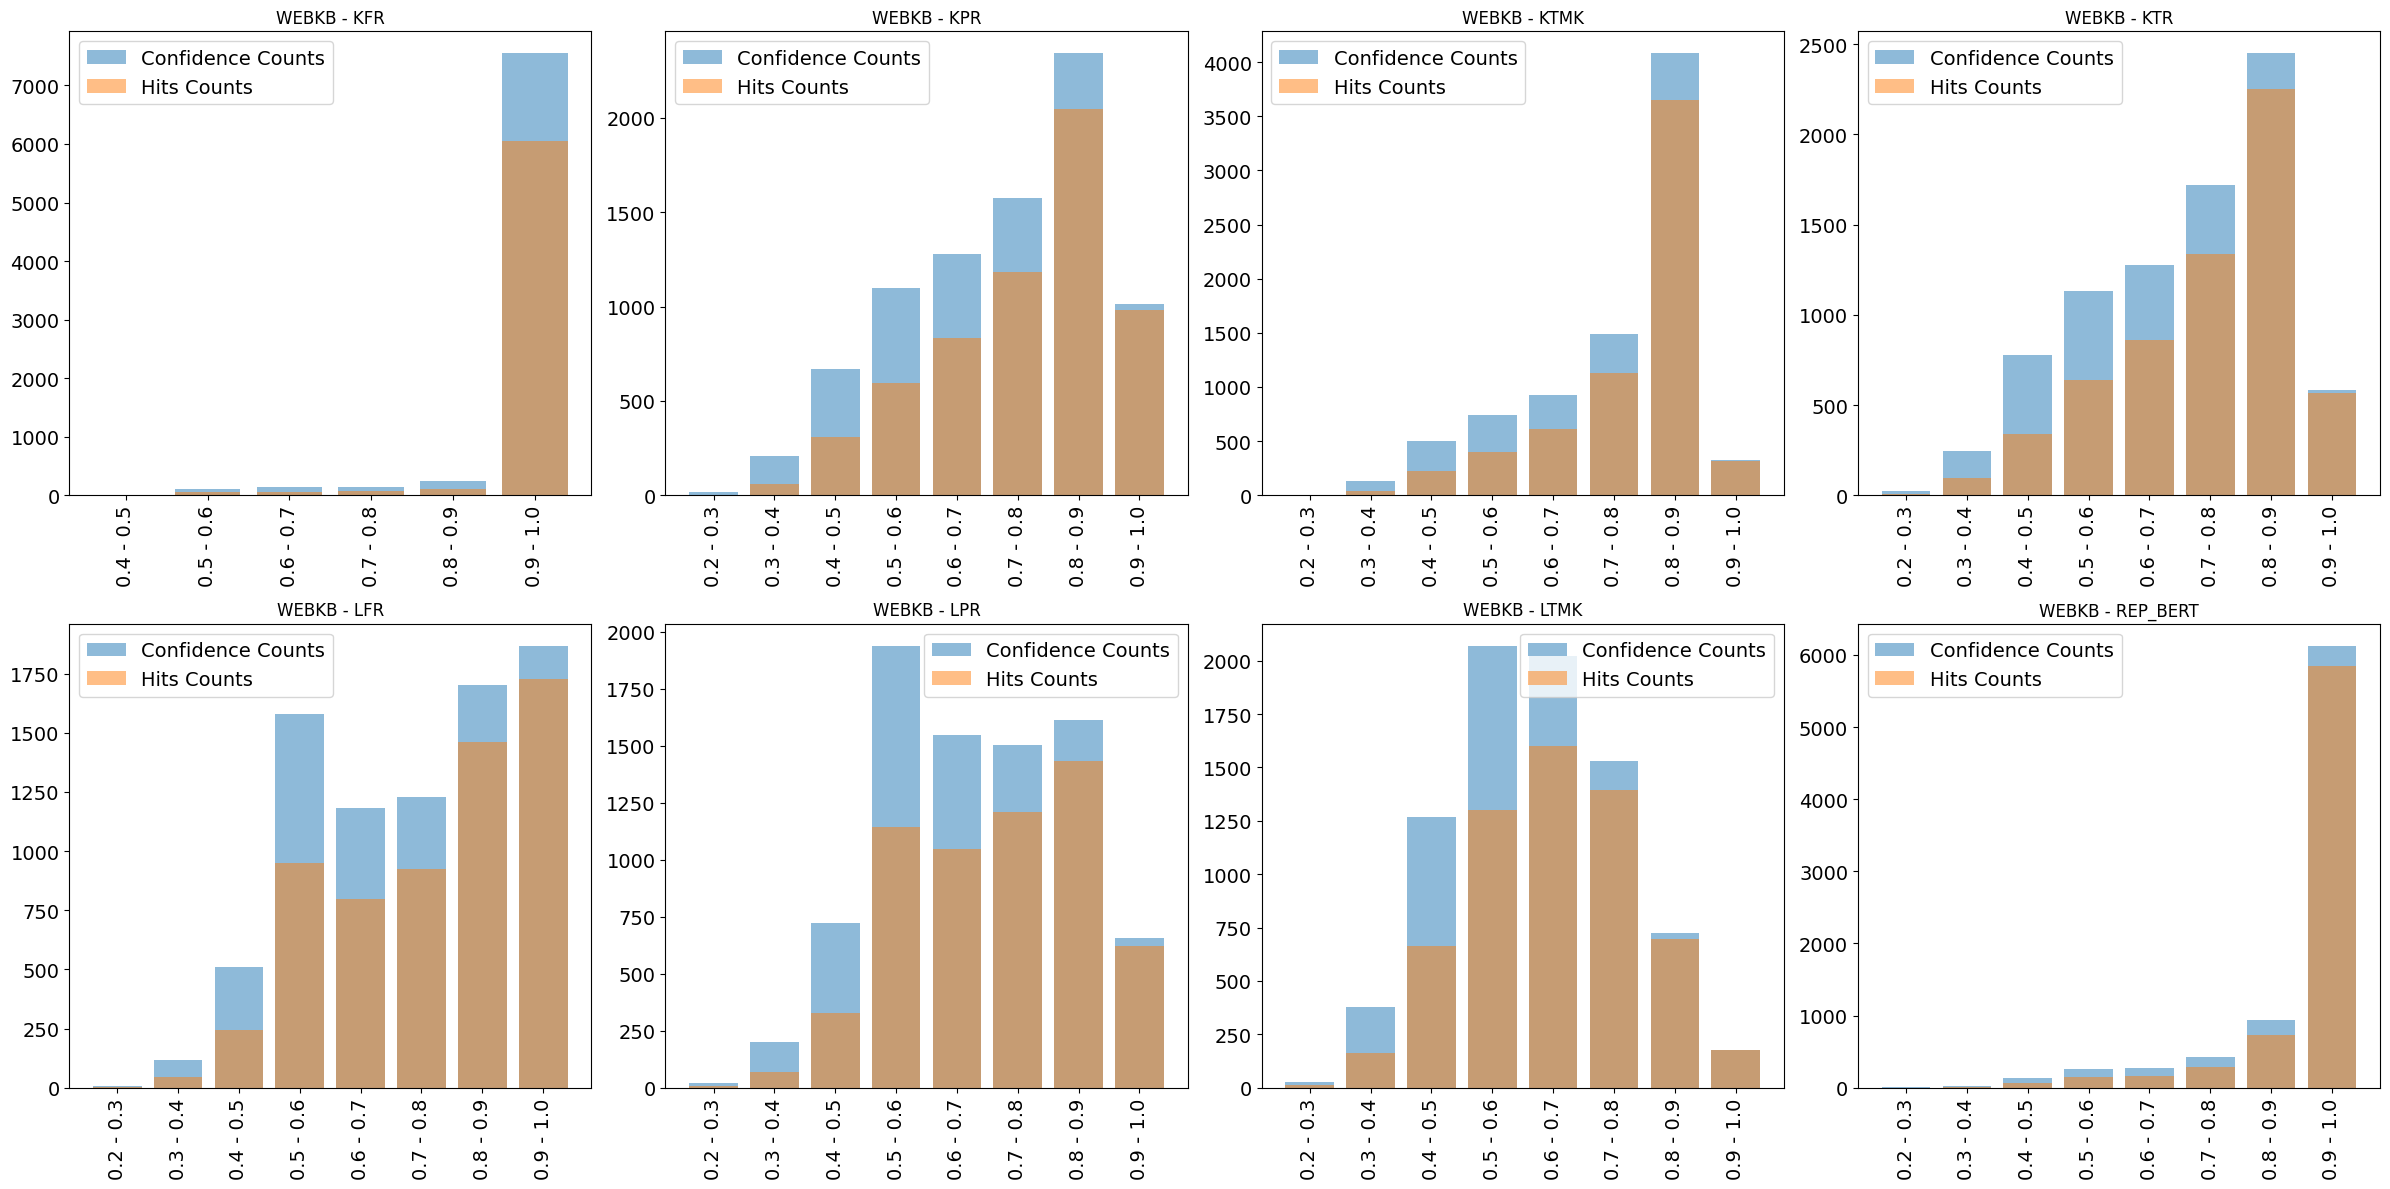

In [47]:
#CLFS_PLOT = ["ktmk", "ltmk", "stmk", "xtmk"]
#CLFS_PLOT = ["xpr", "xfr", "xtmk", "kfr"]
#CLFS_PLOT = ["kfr", "kpr", "ktmk", "ktr"]
CLFS_PLOT = ["kfr", "kpr", "ktmk", "ktr", "lfr", "lpr", "ltmk", "rep_bert"]
#grid_data = ["webkb", "20ng", "acm", "reut"]
grid_data = ["webkb"]
plt.figure(figsize=(24, 12))
for plot_idx, (dset, clf) in enumerate(product(grid_data, CLFS_PLOT)):
    #plt.subplot(len(grid_data), len(CLFS_PLOT), plot_idx + 1)
    plt.subplot(2, 4, plot_idx + 1)
    plot_proba_dist(d_probas, pd_datasets, dset, clf)
    plt.title(f"{dset.upper()} - {clf.upper()}")
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
plt.tight_layout()

# PTE

KeyError: 'spr'

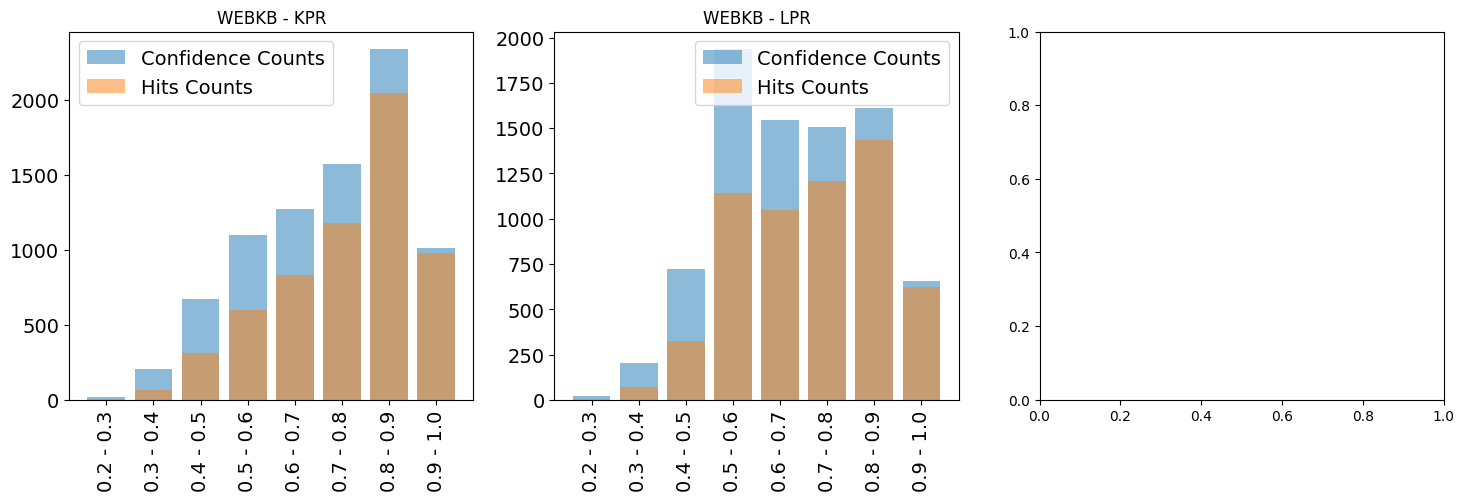

In [48]:
CLFS_PLOT = ["kpr", "lpr", "spr", "xpr"]
grid_data = ["webkb", "20ng", "acm", "reut"]
plt.figure(figsize=(24, 22))
for plot_idx, (dset, clf) in enumerate(product(grid_data, CLFS_PLOT)):
    plt.subplot(len(grid_data), len(CLFS_PLOT), plot_idx + 1)
    plot_proba_dist(d_probas, pd_datasets, dset, clf)
    plt.title(f"{dset.upper()} - {clf.upper()}")
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
plt.tight_layout()

# TF-IDF

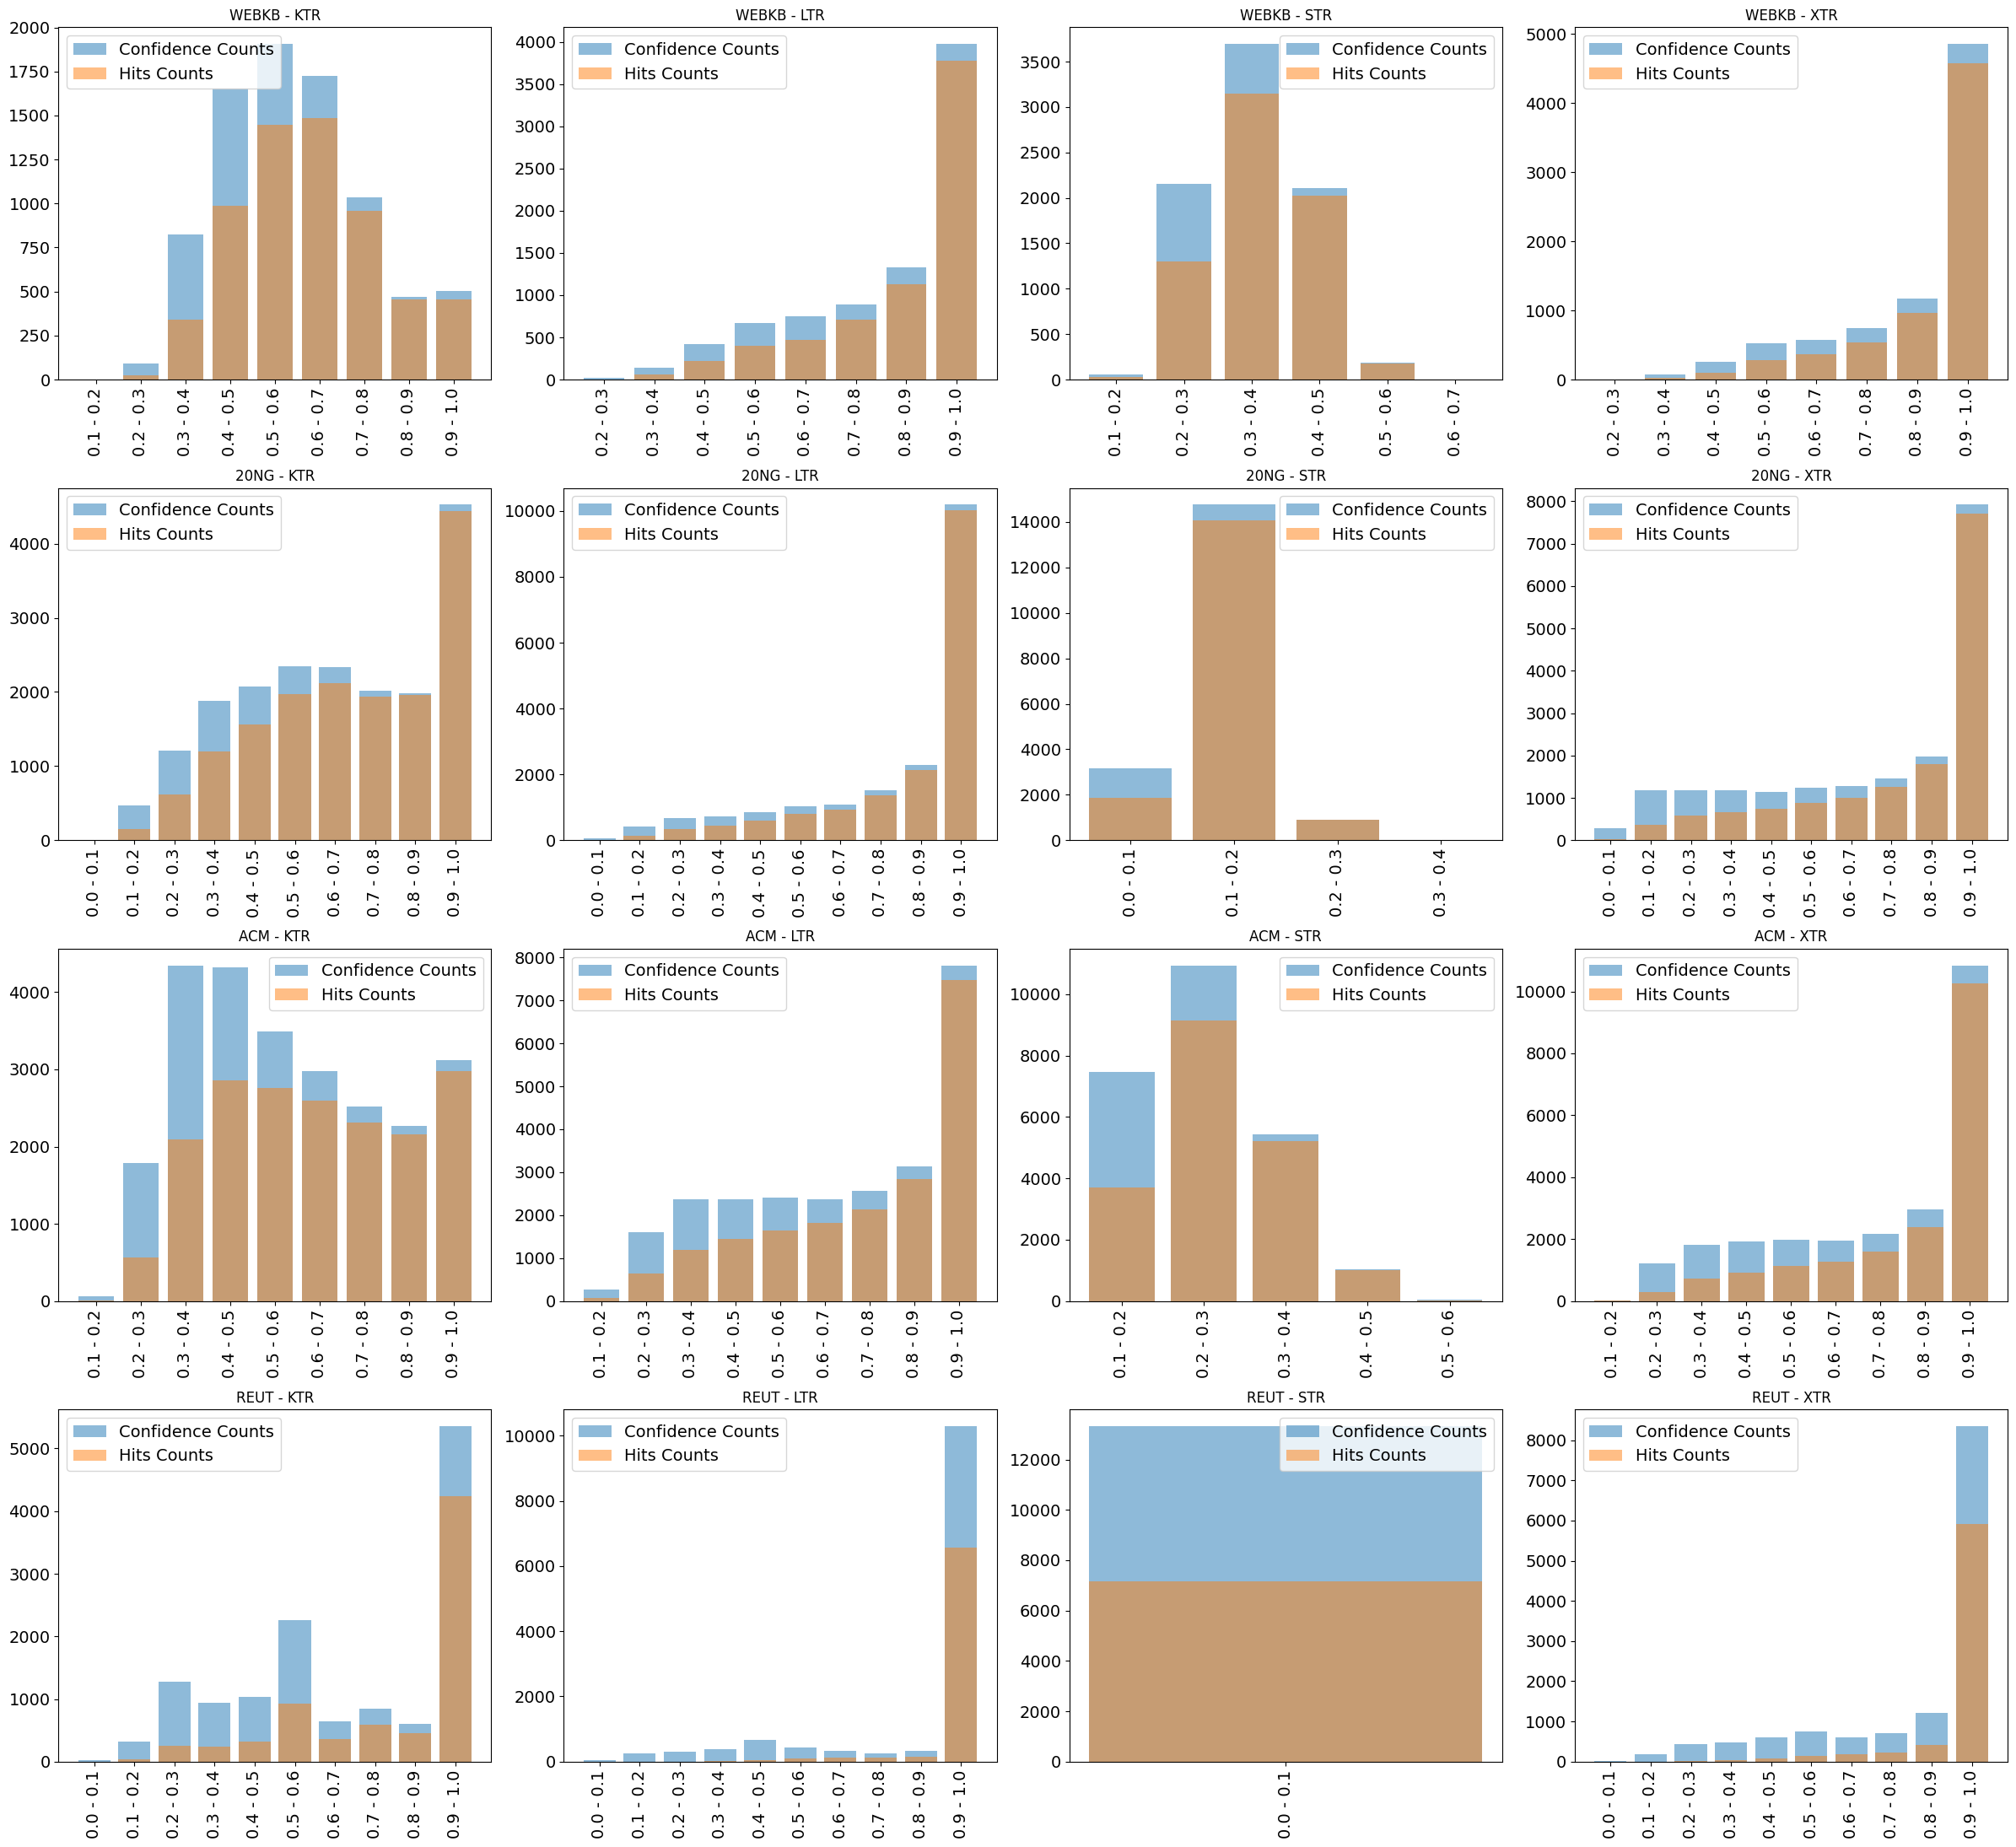

In [ ]:
CLFS_PLOT = ["ktr", "ltr", "str", "xtr"]
grid_data = ["webkb", "20ng", "acm", "reut"]
plt.figure(figsize=(24, 22))
for plot_idx, (dset, clf) in enumerate(product(grid_data, CLFS_PLOT)):
    plt.subplot(len(grid_data), len(CLFS_PLOT), plot_idx + 1)
    plot_proba_dist(d_probas, pd_datasets, dset, clf)
    plt.title(f"{dset.upper()} - {clf.upper()}")
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
plt.tight_layout()

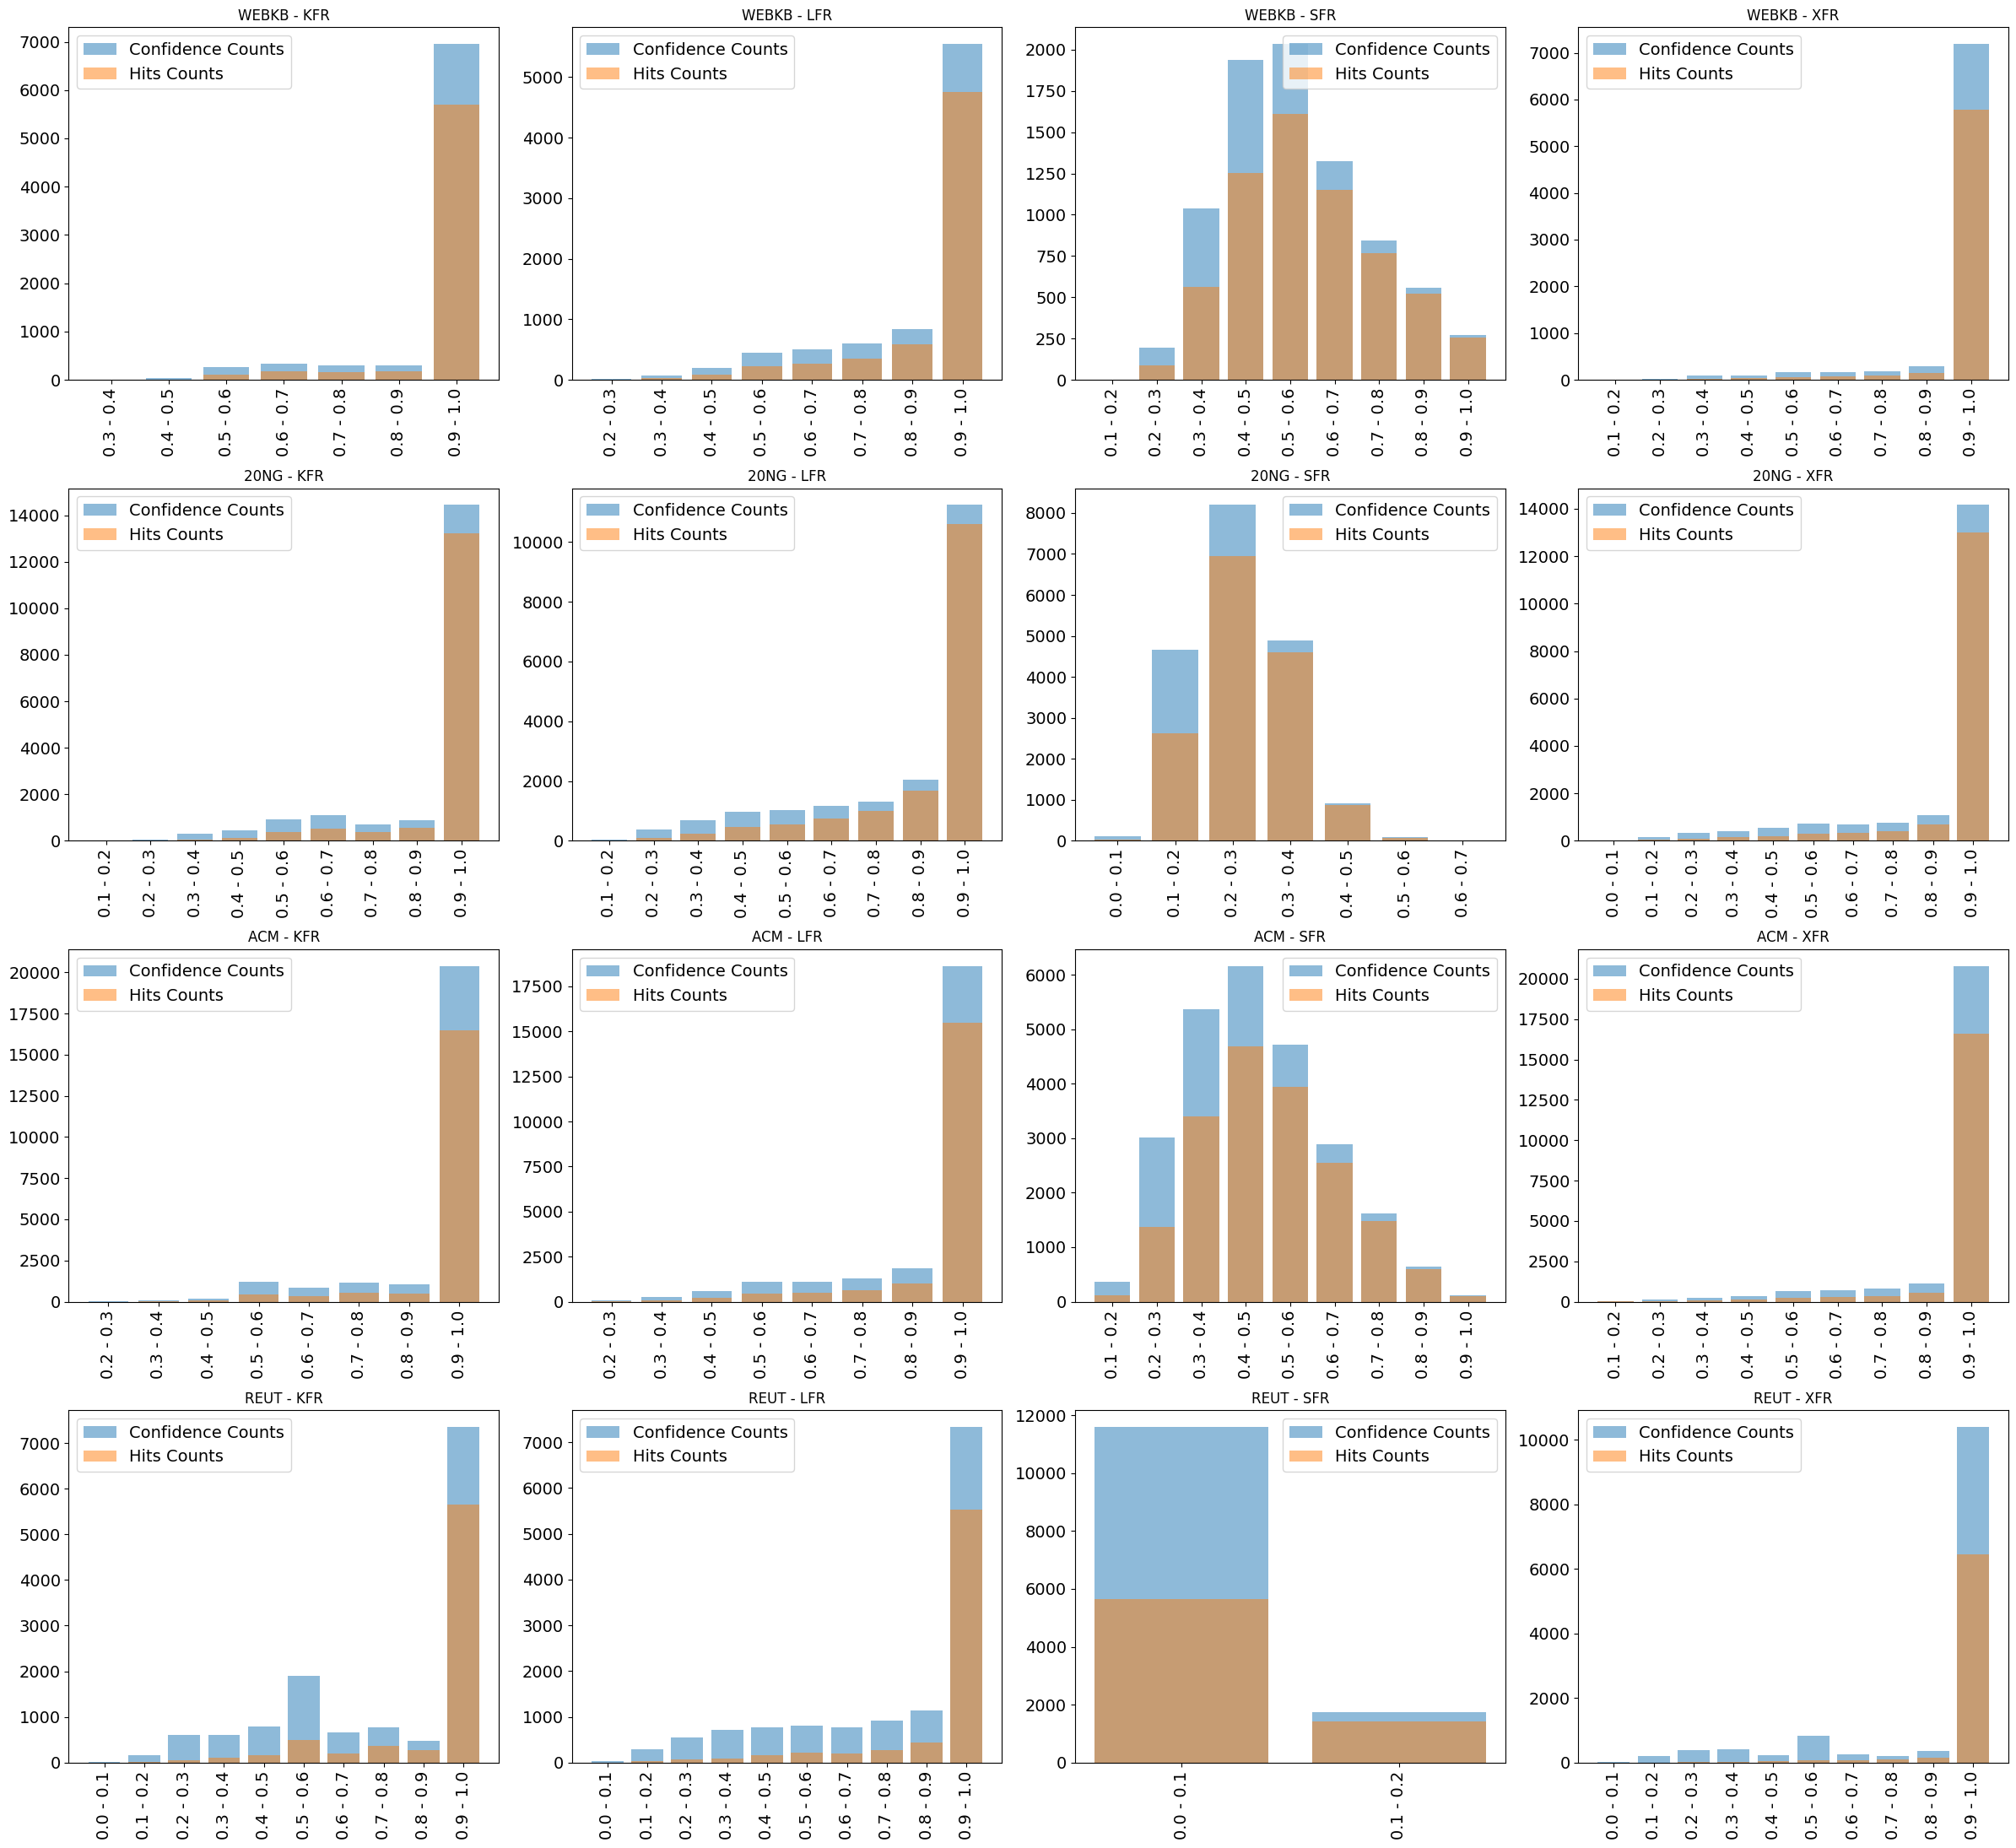

In [ ]:
CLFS_PLOT = ["kfr", "lfr", "sfr", "xfr"]
grid_data = ["webkb", "20ng", "acm", "reut"]
plt.figure(figsize=(24, 22))
for plot_idx, (dset, clf) in enumerate(product(grid_data, CLFS_PLOT)):
    plt.subplot(len(grid_data), len(CLFS_PLOT), plot_idx + 1)
    plot_proba_dist(d_probas, pd_datasets, dset, clf)
    plt.title(f"{dset.upper()} - {clf.upper()}")
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
plt.tight_layout()

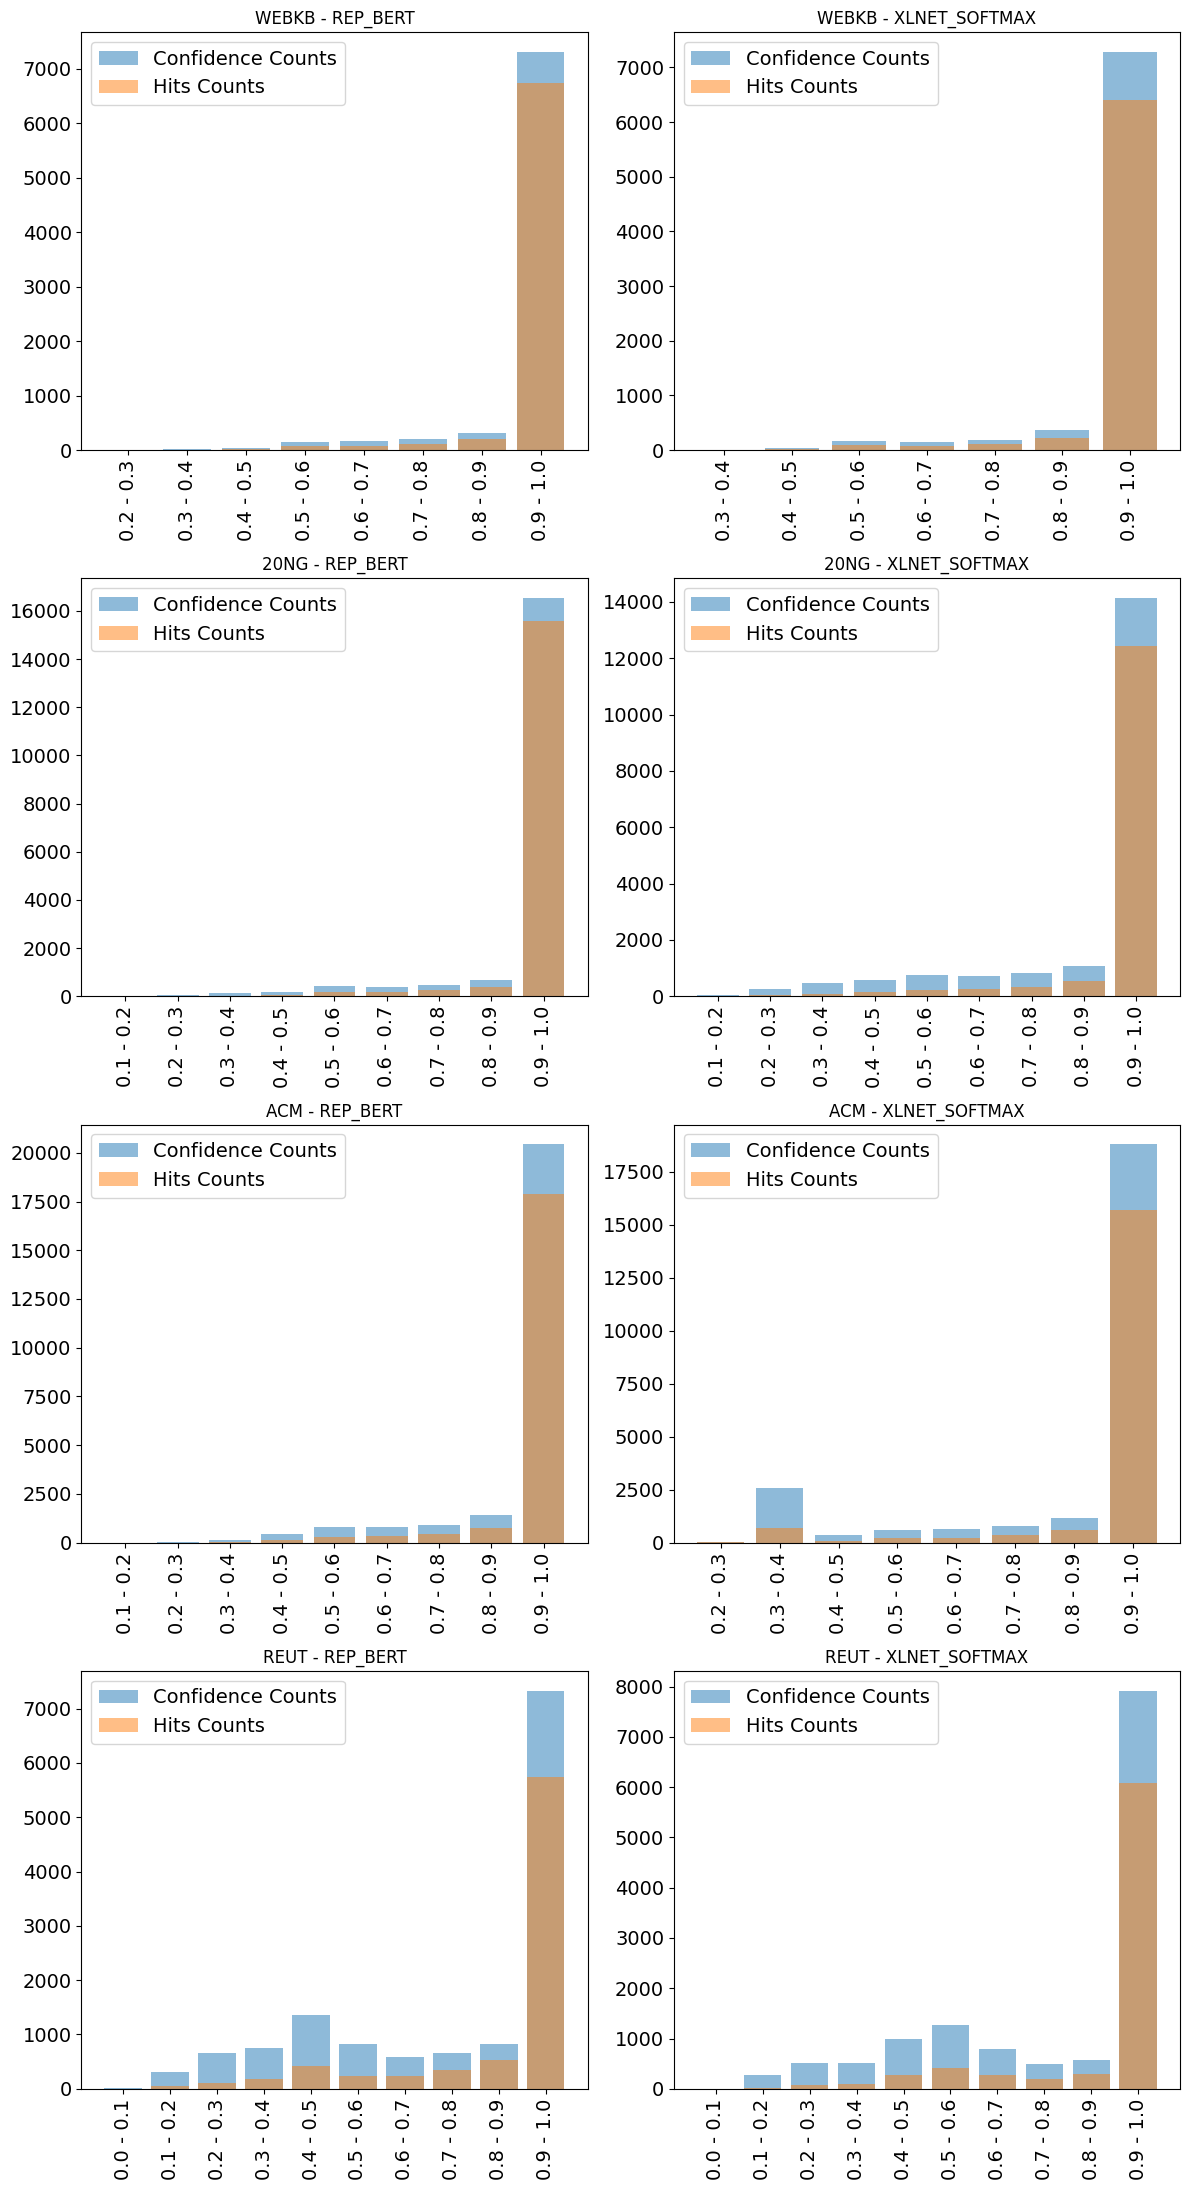

In [ ]:
CLFS_PLOT = ["rep_bert", "xlnet_softmax"]
grid_data = ["webkb", "20ng", "acm", "reut"]
plt.figure(figsize=(12, 22))
for plot_idx, (dset, clf) in enumerate(product(grid_data, CLFS_PLOT)):
    plt.subplot(len(grid_data), len(CLFS_PLOT), plot_idx + 1)
    plot_proba_dist(d_probas, pd_datasets, dset, clf)
    plt.title(f"{dset.upper()} - {clf.upper()}")
    _ = plt.xticks(fontsize=14)
    _ = plt.yticks(fontsize=14)
plt.tight_layout()